In [35]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import backend, models
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!ls /home/jupyter/.kaggle

kaggle.json


In [3]:
!mv kaggle.json /home/jupyter/.kaggle

mv: cannot stat 'kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d gpiosenka/100-bird-species

100-bird-species.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip 100-bird-species.zip -d dataset1

Archive:  100-bird-species.zip
replace dataset1/EfficientNetB4-BIRDS-0.99.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
PATH = 'dataset'
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'valid')
test_dir = os.path.join(PATH, 'test')

In [3]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 64
IMG_WIDTH = 64

In [4]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

In [5]:
train_data_gen = train_image_generator.flow_from_directory(train_dir, 
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           batch_size=batch_size,
                                                           shuffle=True)
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              batch_size=batch_size,
                                                              shuffle=True)
test_data_gen = test_image_generator.flow_from_directory(test_dir,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='categorical',
                                                         batch_size=batch_size,
                                                         shuffle=True)

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


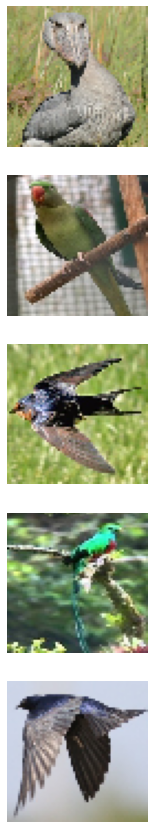

In [6]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
    plt.show()
    
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [13]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(64, 64, 3))) #64
model.add(Conv2D(64, (3, 3), activation='relu')) # 62
model.add(MaxPooling2D((2, 2))) #31
model.add(Conv2D(128, (3, 3), activation='relu')) # 29.
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu')) # 27
model.add(MaxPooling2D(2, 2)) # 14
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(400, activation='softmax'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 conv2d_19 (Conv2D)          (None, 62, 62, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_20 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 batch_normalization (BatchN  (None, 29, 29, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_21 (Conv2D)          (None, 27, 27, 128)      

In [14]:
adam = Adam(learning_rate=0.001)
model.compile(optimizer= adam,
              loss=tf.keras.losses.
              CategoricalCrossentropy(), metrics=['accuracy'])

In [15]:
history = model.fit( 
    train_data_gen, 
    steps_per_epoch = len(train_data_gen), 
    epochs = 50,
    validation_data = val_data_gen,
    validation_steps = len(val_data_gen),
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.7, #   T0.2 to 0.5 dropped to fast 0.7
                                 patience = 2, verbose = 1)])

Epoch 1/50
457/457 [==============================] - 1533s 3s/step - loss: 5.5831 - accuracy: 0.0133 - val_loss: 4.8849 - val_accuracy: 0.0380 - lr: 0.0010
Epoch 2/50
457/457 [==============================] - 1492s 3s/step - loss: 4.8089 - accuracy: 0.0491 - val_loss: 4.0639 - val_accuracy: 0.1185 - lr: 0.0010
Epoch 3/50
457/457 [==============================] - 1489s 3s/step - loss: 4.1182 - accuracy: 0.1259 - val_loss: 3.5030 - val_accuracy: 0.2170 - lr: 0.0010
Epoch 4/50
457/457 [==============================] - 1486s 3s/step - loss: 3.5633 - accuracy: 0.2059 - val_loss: 2.7620 - val_accuracy: 0.3535 - lr: 0.0010
Epoch 5/50
457/457 [==============================] - 1488s 3s/step - loss: 3.1416 - accuracy: 0.2801 - val_loss: 2.6312 - val_accuracy: 0.3845 - lr: 0.0010
Epoch 6/50
457/457 [==============================] - 1493s 3s/step - loss: 2.8033 - accuracy: 0.3416 - val_loss: 2.3705 - val_accuracy: 0.4460 - lr: 0.0010
Epoch 7/50
457/457 [==============================] - 1487

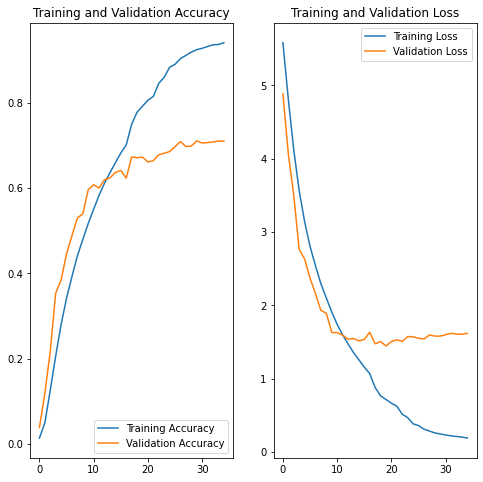

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(35)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1) 
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
test_loss, test_acc = model.evaluate(test_data_gen, verbose=2)

16/16 - 14s - loss: 1.3693 - accuracy: 0.7330 - 14s/epoch - 880ms/step


In [45]:
from tensorflow.math import confusion_matrix

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [22]:
tflite_model = converter.convert()

2022-05-24 05:53:04.009438: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpovxkgp9x/assets


2022-05-24 05:53:06.674259: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-05-24 05:53:06.674321: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-05-24 05:53:06.676471: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpovxkgp9x
2022-05-24 05:53:06.681412: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-05-24 05:53:06.681448: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpovxkgp9x
2022-05-24 05:53:06.685415: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-05-24 05:53:06.704379: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-05-24 05:53:06.894747: I tensorflow/cc/saved_model/loader.cc:212] Running in

In [23]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [25]:
model.save('birds-100-species.h5')

In [41]:
Y_pred = model.predict(test_data_gen, test_data_gen.samples // batch_size+1)

In [52]:
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_data_gen.classes, y_pred))
#print('Classification Report')
#target_names = ['Cats', 'Dogs', 'Horse']
#print(classification_report(test_data_gen.classes, y_pred, target_names=target_names))

Confusion Matrix
tf.Tensor(
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], shape=(400, 400), dtype=int32)
